In [36]:
#counts # of comments in a post for a givne ID

import json

def count_comments(file, uid):
    with open(file, 'r') as f:
        data = json.load(f)
        posts = data['posts']
        for post in posts:
            if post['id'] == uid:
                i = 0
                stack = []
                comments = post['comments']

                stack = comments
                while stack != []:  
                    comment = stack.pop()
                    i+=1
                    if len(comment['comments']) > 0:
                        stack = stack + comment['comments']

                return i

count_comments('data/Dogecoin-2022-05-04-01-50-29.json', 'uhdmuq')

FileNotFoundError: [Errno 2] No such file or directory: 'data/Dogecoin-2022-05-04-01-50-29.json'

In [7]:
import os
import pandas as pd
import json

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure




l = []
for file in os.listdir(os.path.join('../data')):
    if file.endswith(".json"):

        with open("../data/"+file, 'r') as f:
            data = json.load(f)
            posts = data['posts']
            s = data['subreddit']
            for post in posts:
                    i = 0
                    stack = []
                    comments = post['comments']
                    stack = comments
                    while stack != []:  
                        comment = stack.pop()
                        l.append((comment['id'], comment['author'], comment['score'], comment['created_utc'], comment['depth'],s))
                        if len(comment['comments']) > 0:
                            stack = stack + comment['comments']

df = pd.DataFrame(columns = ["id", "author", "score", "created_utc", "depth","subreddit"], data=l)
df = df.astype({'created_utc': 'int64'})
df.sort_values(by=['created_utc'], inplace=True)
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

df['date'] = df['created_utc'].dt.date

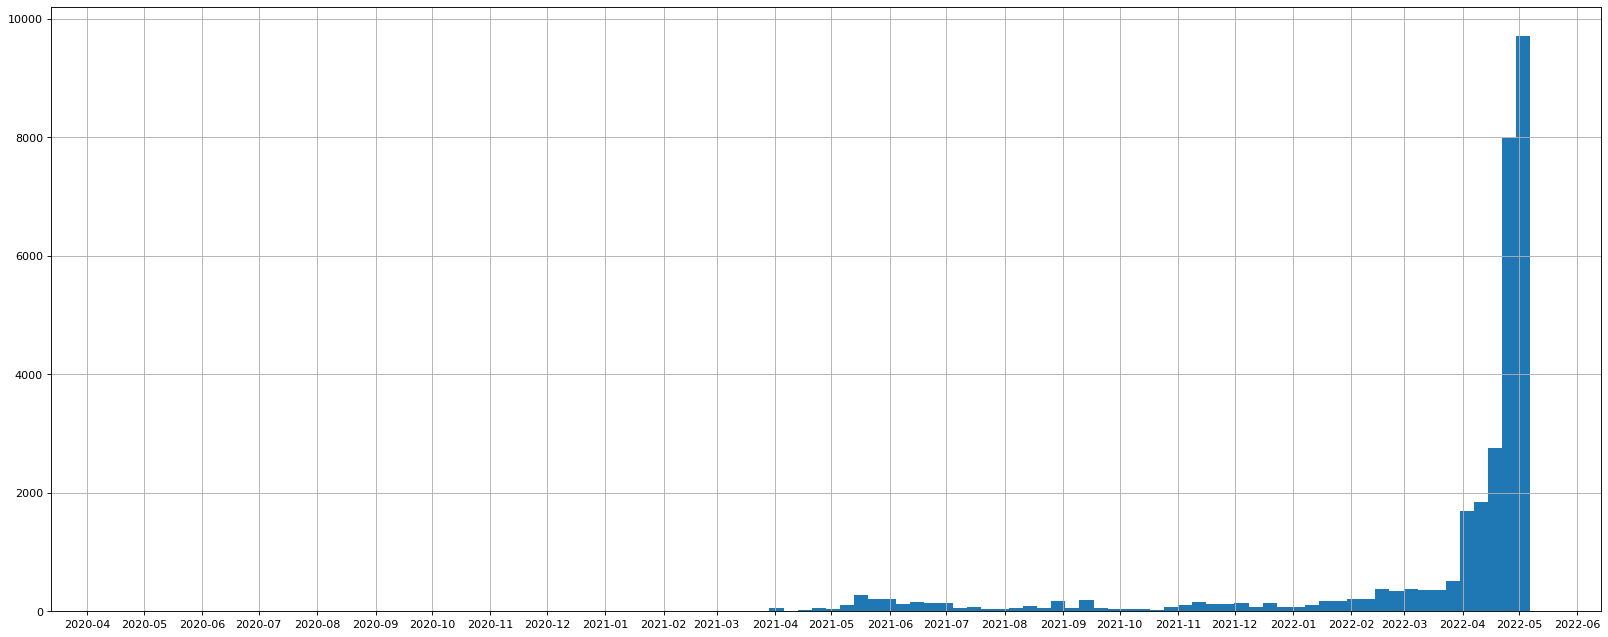

In [3]:
# dates
import matplotlib.dates as mdates
figure(figsize=(25, 10), dpi=80)
ax = df['date'].hist(bins=100)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

In [4]:
ua=len(pd.unique(df['author']))
a=len(df['author'])
print(f"{ua} unique authors in {a} comments, ratio:{ua/a}")

vc = df['author'].value_counts()


print(f'users who posted more than 1 comment: {len(vc[vc>1])}')
print(f'users who posted more than 2 comments: {len(vc[vc>2])}')
print(f'users who posted more than 3 comments: {len(vc[vc>3])}')
print(f'users who posted more than 5 comments: {len(vc[vc>5])}')
print(f'users who posted more than 10 comments: {len(vc[vc>10])}')
print(f'users who posted more than 50 comments: {len(vc[vc>50])}')
print(f'users who posted more than 100 comments: {len(vc[vc>100])}')

14018 unique authors in 30747 comments, ratio:0.4559143981526653
users who posted more than 1 comment: 4536
users who posted more than 2 comments: 2386
users who posted more than 3 comments: 1562
users who posted more than 5 comments: 838
users who posted more than 10 comments: 307
users who posted more than 50 comments: 17
users who posted more than 100 comments: 3


In [5]:
start_date = pd.to_datetime("2022-4-1").date()
after_april_2022 = df[(df['date'] >= start_date)]

print(f'ratio of posts >= 1. april 2022: {len(after_april_2022)/len(df)}')

ratio of posts >= 1. april 2022: 0.7743844927960452


In [13]:
grouped_df = df.groupby(["author"])
f=grouped_df['score'].agg('sum')
f

author
--Imposter--            5
--Slipp3ry__Snak3--    18
-Afro_Senpai-          12
-Aporia                68
-Captain-               3
                       ..
zweieinseins211         5
zxr01                  17
zxygambler             17
zygodontfario53        19
zyppoboy                3
Name: score, Length: 14018, dtype: int64

In [34]:
f = df[["author", "subreddit"]].groupby(["author"])
f2 = f['subreddit'].apply(list)
f2

author
--Imposter--                                                   [Binance]
--Slipp3ry__Snak3--                                 [Ethereum, Ethereum]
-Afro_Senpai-                                         [BitcoinBeginners]
-Aporia                [Ethereum, Ethereum, Ethereum, Ethereum, Crypt...
-Captain-                                                     [Dogecoin]
                                             ...                        
zweieinseins211                                                [Bitcoin]
zxr01                  [BitcoinBeginners, BitcoinBeginners, BitcoinBe...
zxygambler                                            [Bitcoin, Bitcoin]
zygodontfario53                           [CryptoMarkets, CryptoMarkets]
zyppoboy                                                      [Dogecoin]
Name: subreddit, Length: 14018, dtype: object

In [47]:
def jsonToEdgeList(file):
    with open(file, 'r') as f:
        subreddit = json.load(f)
        assert subreddit['subreddit'] is not None, "subreddit name cannot be None"
        assert subreddit['posts'] is not None, "subreddit name cannot be None"
        for post in subreddit['posts']:
            postToEdgeList(post, subreddit['subreddit'])

def postToEdgeList(post,subreddit):
    commentsToEdgeList(post['comments'], [(post['author'], 1)])

l = []
edges = {}
vertices = {}
    
def commentsToEdgeList(comments, context):

    for comment in comments:
        current_comment_author = comment['author']
        for prev_author, depth in context:
            if prev_author != current_comment_author: #avoid self loops
                key = (current_comment_author, prev_author)
                if key not in edges.keys():
                    edges[key] = comment['score']/depth
                else:
                    w = edges[key]
                    edges[key] = w + comment['score']/depth
        if len(comment['comments']) > 0:
            commentsToEdgeList(comment['comments'], context + [(current_comment_author, comment['score'])])
    
    
jsonToEdgeList('../data/Binance-2022-05-04-01-50-29.json')

In [208]:
import json
import os
import pandas as pd

class CSVDumper():
    def __init__(self):
        self.edges = { 'deep_link' : {}, 'next_link': {}} # keys=(source,target), val weight
        self.vertices = {}
        self.data = []
        
    def parse_json_file(self, file):
        with open(file, 'r') as f:
            subreddit = json.load(f)
            assert subreddit['subreddit'] is not None, "subreddit name cannot be None"
            assert subreddit['posts'] is not None, "subreddit posts cannot be empty"

            for post in subreddit['posts']:

                self.parse_comments_pd(post, subreddit['subreddit']) #for internal pd data frame

                self.parse_comments_deep_link(post['comments'], [(post['author'], 1)], subreddit['subreddit'])
                self.parse_comments_next_link(post['comments'], [(post['author'], 1)], subreddit['subreddit'])

    def parse_comments_pd(self, post, sub):
        self.data.append((post['id'], post['author'], post['score'], post['created_utc'], 1, sub))
        self.parse_comments_pd_r(post['comments'], sub)

    def parse_comments_pd_r(self, comments, sub):
        for comment in comments:
            self.data.append((comment['id'], comment['author'], comment['score'], comment['created_utc'], comment['depth'], sub))
            if len(comment['comments']) > 0:
                self.parse_comments_pd_r(comment['comments'], sub)

    def parse_comments_deep_link(self,comments,context, sub):
        for comment in comments:
            for prev_author, depth in context:
                if prev_author != comment['author']: #avoid self loops
                    key = (comment['author'], prev_author)
                    
                    #insert/update edge
                    if key not in self.edges['deep_link'].keys():
                        self.edges['deep_link'][key] = comment['score']/depth
                    else:
                        w = self.edges['deep_link'][key]
                        self.edges['deep_link'][key] = w + comment['score']/depth
                        
            if len(comment['comments']) > 0:
                self.parse_comments_deep_link(comment['comments'], context + [(comment['author'], comment['depth'])], sub)
    
    def parse_comments_next_link(self,comments,context, sub):
        for comment in comments:
            for prev_author, depth in context:
                if prev_author != comment['author']: #avoid self loops
                    key = (comment['author'], prev_author)
                    
                    #insert/update edge
                    if key not in self.edges['next_link'].keys():
                        self.edges['next_link'][key] = comment['score']/depth
                    else:
                        w = self.edges['next_link'][key]
                        self.edges['next_link'][key] = w + comment['score']/depth
                        
            if len(comment['comments']) > 0:
                self.parse_comments_next_link(comment['comments'], [context[0],(comment['author'], comment['depth'])], sub)



    def parse_folder(self, folder):
        for file in os.listdir(os.path.join(folder)):
            if file.endswith(".json"):
                self.parse_json_file(os.path.join(folder, file))

    def prep_df(self):
        df = pd.DataFrame(columns = ["id", "author", "score", "created_utc", "depth","subreddit"], data=self.data)
        df = df.astype({'created_utc': 'int64'})
        df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
        return df
    
    def dump_scores(self,file):
        grouped_df = self.prep_df().groupby(["author"])
        s = grouped_df['score'].agg('sum')
        s.index.names = ['Id']
        s.to_csv(file)

    def dump_active_subs(self,file):
        df = self.prep_df()
        g = df[["author", "subreddit"]].groupby(["author"])
        g = g['subreddit'].apply(list)
        g.index.names = ['Id']
        g.to_csv(file)
        
    def dump_edges(self, link, file):
        d = [ (source,target,weight) for (source,target), weight in self.edges[link].items() ]
        pd.DataFrame(columns = ["source", "target", "weight"],data=d).to_csv(file, index=False)
    
    def dump_gephi(self,file):
        pass

    def debug(self):
        return self.data

    
dp = CSVDumper()
dp.parse_folder('test_data')
dp.dump_scores('test_data/csv/scores.csv')
dp.dump_active_subs('test_data/csv/subs.csv')
dp.dump_edges('next_link', 'test_data/csv/edges_next.csv')
dp.dump_edges('deep_link', 'test_data/csv/edges_deep.csv')


,id,author,score,created_utc,depth,subreddit
0,tyhpab,user1,3,2022-04-07 17:09:44,1,Binance
1,i3sg5wq,user2,3,2022-04-07 17:52:58,1,Binance
2,i3sg5wq,user3,5,2022-04-07 17:52:58,2,Binance
3,i3sg5wq,user4,10,2022-04-07 17:52:58,3,Binance
4,i3sg5wq,user5,3,2022-04-07 17:52:58,4,Binance
5,tyhpab,user2,3,2022-04-07 17:09:44,1,Binance
6,i3sg5wq,user3,3,2022-04-07 17:52:58,1,Binance
7,i3sg5wq,user4,3,2022-04-07 17:52:58,2,Binance
8,i3sg5wq,user2,3,2022-04-07 17:52:58,3,Binance
9,i3sg5wq,user3,3,2022-04-07 17:52:58,4,Binance


In [215]:
l1 = [1,2,3,4,5]
l2 = [10,11,12,13,14]

g=set()
for x in l1:
    for y in l2:
        g.add({x,y})
        
g

TypeError: unhashable type: 'set'

In [273]:
# First import the libraries that we need to use
import pandas as pd
import requests
import json

#fetches 24h-1s from start in 5 min intervals
def fetch_daily_data(symbol, start):
    pair_split = symbol.split('/')  # symbol must be in format XXX/XXX ie. BTC/EUR
    symbol = pair_split[0] + '-' + pair_split[1]
    end = start + 60*60*24 - 1
    url = f'https://api.pro.coinbase.com/products/{symbol}/candles?granularity=300&start={start}&end={end}'
    response = requests.get(url)
    if response.status_code == 200:  # check to make sure the response from server is good
        data = pd.DataFrame(json.loads(response.text), columns=['unix', 'low', 'high', 'open', 'close', 'volume'])
        data['date'] = pd.to_datetime(data['unix'], unit='s')  # convert to a readable date
        data['vol_fiat'] = data['volume'] * data['close']      # multiply the BTC volume by closing price to approximate fiat volume

        # if we failed to get any data, print an error...otherwise write the file
        if data is None:
             print("Did not return any data from Coinbase for this symbol")
        else:
             #data.to_csv(f'Coinbase_{pair_split[0] + pair_split[1]}_dailydata.csv', index=False)
            return data
    else:
        print(response.status_code)
        print("Did not receieve OK response from Coinbase API")



def fetch_monthly_data(symbol, start):
    for i in range(0,10):
        start = start+i*24*60*60
        sle
    
pair = "BTC/USD"
#1.4.22 00:00 = 1648771200
data = fetch_daily_data("BTC/USD", 1648771200)

fetch_monthly_data("BTC/USD", 1648771200)

0
1
2
3
4
5
6
7
8
9


In [250]:
import datetime
print(datetime.datetime.fromtimestamp(1648764000).date())

2022-04-01
